# Truth Comparison

In [1]:
import os
import sys
from pathlib import Path

repo_root = Path(os.getcwd()).parent
sys.path.insert(0, str(repo_root))

In [2]:
from collections import defaultdict
from itertools import product

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
from scipy.integrate import simps
from scipy.ndimage import gaussian_filter1d

from pipeline import data_dir, harmony
from harmonia.algorithms import CartesianArray
from harmonia.cosmology import BaseModel, scale_dependence_modification
from harmonia.reader import CartesianMultipoles
from harmonia.surveyor.synthesis import CovarianceEstimator

plt.style.use(harmony)

In [3]:
TRACER = "halos"
SERIES = '-cut_2'
CONTRAST = 50.
SCALE_TAG = "[None,0.09]"
ORDER_TAG = "[0]"
RSD_TAG = "False"

CASE = "full"  # "partial"
NG = 100  # 100
MODE = "data"  # 

if CASE == "full":
    MASK_TAG = "1.0"
    SELECTION_TAG = "None"
if CASE == "partial":
    MASK_TAG = "random0_BOSS_DR12v5_CMASS_North"
    SELECTION_TAG = "[100.0,500.0]"

if NG == 0:
    serials, density, bias = range(1, 1+24), 4.75e-5, 3.551
    b_1 = {'std': 3.52, 'hyb': 3.51} if CASE == "full" else {'std': 3.54, 'hyb': 3.50}
    f_nl = {'std': 6., 'hyb': 18.} if CASE == "full" else {'std': -40., 'hyb': 11.}
if NG == 100:
    serials, density, bias = range(1, 1+20), 4.91e-5, 3.485
    b_1 = {'std': 3.48, 'hyb': 3.46} if CASE == "full" else {'std': 3.50, 'hyb': 3.46}
    f_nl = {'std': 89., 'hyb': 117.} if CASE == "full" else {'std': 62., 'hyb': 111.}

In [4]:
# Map source
source_tags = list(product([TRACER,], ["NG={}.".format(NG),], [SERIES,], serials))

map_data_dir = data_dir/"raw"/"catalogue_maps"
map_data_file = "catalogue-map-({}).npz".format(",".join([
    "source={}-({},z=1.){}-{}",
    "map=cartesian",
    "scale={}".format(SCALE_TAG),
    "orders={}".format(ORDER_TAG),
    "rsd={}".format(RSD_TAG),
    "mask={}".format(MASK_TAG),
    "selection={}".format(SELECTION_TAG),
]))

# Likelihood source
likelihood_file = data_dir/"processed"/"likelihoods"/"posterior-grid_{}-sky_NG{}.npz".format(CASE, NG)

# Survey specs
survey_product_dir = data_dir/"processed"/"survey_products"

mask_or_file_info = ",".join([
    "orders=[0,2,4,6,8]", "boxsize=1000.0", "expansion=70.0", "mesh=768",
    "mask={}".format(MASK_TAG), "selection={}".format(SELECTION_TAG),
])

mask_file = "mask-({}).npy".format(mask_or_file_info)
window_file = "window-({}).npz".format(mask_or_file_info)

# Covariance estimation
covariance_estimate_info = ",".join([
    "source=1-2500", "map=cartesian", "boxsize=1000.0",
    "scale={}".format(SCALE_TAG), "orders={}".format(ORDER_TAG),
    "mask={}".format(MASK_TAG), "selection={}".format(SELECTION_TAG),
])

covariance_estimate_file = "covar-estimate-({}).npz".format(covariance_estimate_info)

# Cosmo specs
cosmo_dir = data_dir/"external"/"cosmology"
cosmo_file = "simulation-GadgetAHF.txt"

In [5]:
# Get measurements.
_wavenumbers = []
_multipoles = defaultdict(list)
for source_tag in source_tags:
    map_data = CartesianArray.load(map_data_dir/map_data_file.format(*source_tag))

    _wavenumbers.append(np.unique(map_data.array['wavenumber']))
    for ell in np.unique(map_data.array['order']):
        power = map_data.array['power'][map_data.array['order'] == ell]
        _multipoles[ell].append(power)

wavenumbers = np.mean(_wavenumbers, axis=0)
multipoles = {ell: np.mean(_multipoles[ell], axis=0) for ell in _multipoles.keys()}

# Get survey window.
mask_multipoles = np.load(survey_product_dir/mask_file)
window_multipoles = CartesianArray.load(survey_product_dir/window_file)

# Get covariance estimate.
if MODE == 'data':
    covariance_estimator = CovarianceEstimator.load(survey_product_dir/covariance_estimate_file)

    std_estimate = np.sqrt(np.diag(
        covariance_estimator.get_fiducial_covariance(pivot='order')
    )) / covariance_estimator.get_fiducial_vector(pivot='order')
elif MODE == 'model':
    mode_counts = np.array([18, 128, 314, 584, 1058, 1640, 2000, 2966])
    std_estimate = 1 / np.sqrt(mode_counts)

# Get baseline model.
simulation_cosmo = BaseModel(cosmo_dir/cosmo_file)

cartesian_model = CartesianMultipoles(
    wavenumbers, redshift=1., cosmo=simulation_cosmo, growth_rate=0.,
    mask_multipoles=mask_multipoles if MODE == 'data' else None, 
    window_multipoles=window_multipoles if MODE == 'data' else None, 
)

[2020-07-24 14:59:42 (+0:00:03) INFO] Created cosmological model with parameters:
{'Omega0_b': 0.044, 'Omega0_cdm': 0.226, 'h': 0.7, 'sigma8': 0.8}.


In [6]:
def get_pk_credible_intervals(results):
    SIGMA_LEVEL = 0.393469
    pk = {}
    for case in ['hyb', 'std']:
        log_p, x, y = results['likelihood_'+case], results['f_nl_'+case], results['b_1_'+case]
        
        grid = np.zeros(np.shape(log_p) + (len(wavenumbers),))
        
        posterior = np.exp(log_p - np.max(log_p))
        posterior /= simps([simps(xslice, y) for xslice in posterior], x)
        
        h_flat = np.flip(np.sort(posterior.flatten()))
        cum_h = np.cumsum(h_flat)
        cum_h /= cum_h[-1]
        h_level = h_flat[cum_h <= SIGMA_LEVEL][-1]
        
        for i, row in enumerate(grid):
            for j, element in enumerate(row):
                grid[i, j] = np.empty_like(wavenumbers) * np.nan if posterior[i, j] <= h_level \
                    else cartesian_model.convolved_power_multipoles(
                        orders=[0], b_1=y[j], f_nl=x[i], nbar=density, contrast=CONTRAST
                    ).array['power']
        
        pk[case] = {'low': np.nanmin(grid, axis=(0, 1)), 'high': np.nanmax(grid, axis=(0, 1))}
        
    return pk

In [7]:
likelihood_results = np.load(likelihood_file)

if MODE == 'data':
    # with open("pk-interval_{}-sky_NG{}.txt".format(sys.argv[2], NG), 'w') as f:
    #     print(pk_bound, file=f)
    with open("data_products/pk-interval_{}-sky_NG{}.txt".format(CASE, NG),'r') as f:
        pk_bound = eval(f.read().replace("array", "np.array"))
elif MODE == 'model':
    pk_bound = get_pk_credible_intervals(likelihood_results)

In [8]:
multipole_model_hyb = {
    order: cartesian_model.convolved_power_multipoles(
        orders=[order], b_1=b_1['hyb'], f_nl=f_nl['hyb'], nbar=density, contrast=CONTRAST
    ).array['power']
    for order in multipoles.keys()
}
multipole_model_std = {
    order: cartesian_model.convolved_power_multipoles(
        orders=[order], b_1=b_1['std'], f_nl=f_nl['std'], nbar=density, contrast=CONTRAST
    ).array['power']
    for order in multipoles.keys()
}
multipole_model_ref = {
    order: cartesian_model.convolved_power_multipoles(
        orders=[order], b_1=bias, f_nl=NG, nbar=density, contrast=CONTRAST
    ).array['power']
    for order in multipoles.keys()
}

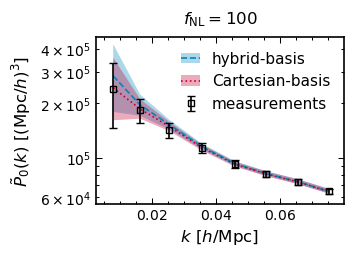

In [9]:
SMOOTH = 0.05
ALPHA = 0.33

fig = plt.figure(figsize=(3.2, 2.2), dpi=100)

ax = fig.add_subplot(111)

ax.errorbar(
    wavenumbers, multipoles[0], 
    yerr=multipoles[0]*std_estimate if MODE == 'data' else multipole_model_true[0]*std_estimate,
    fmt='s', ms=4, mec='k', mfc='none', mew=1., capsize=3., zorder=2, label='measurements'
)
ax.semilogy(
    wavenumbers, gaussian_filter1d(multipole_model_hyb[0], SMOOTH, mode='nearest'),
    ls='--', c='C2', label='hybrid-basis', zorder=1
)
ax.semilogy(
    wavenumbers, gaussian_filter1d(multipole_model_std[0], SMOOTH, mode='nearest'),
    ls=':', c='C1', label='Cartesian-basis', zorder=1
)
ax.fill_between(
    wavenumbers, 
    gaussian_filter1d(pk_bound['hyb']['low'], SMOOTH, mode='nearest'), 
    gaussian_filter1d(pk_bound['hyb']['high'], SMOOTH, mode='nearest'), 
    fc='C2', ec='none', alpha=ALPHA, zorder=-1
)
ax.fill_between(
    wavenumbers, 
    gaussian_filter1d(pk_bound['std']['low'], SMOOTH, mode='nearest'), 
    gaussian_filter1d(pk_bound['std']['high'], SMOOTH, mode='nearest'),
    fc='C1', ec='none', alpha=ALPHA, zorder=-1
)

ax.set_xlim(left=0.0025, right=0.0799)
ax.set_ylim(bottom=5.55e4, top=2.65e5 if NG == 0 else 4.65e5)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlabel(r"$k\ [h/\mathrm{{Mpc}}]$")
ax.set_ylabel(r"$\tilde{P}_0(k)\ [(\mathrm{{Mpc}}/h)^3]$", labelpad=5)

handles, labels = ax.get_legend_handles_labels()
for idx, cc in zip([0, 1], ['C2', 'C1']):
    patch = mpatches.Patch(ec='none', fc=cc, alpha=ALPHA)
    handles[idx] = (handles[idx], patch)

if NG == 100:
    ax.legend(handles, labels, fontsize=11)
ax.set_title(r"$f_\mathrm{{NL}} = {}$".format(NG), pad=10)
fig.savefig("publications/pk-comparison_{}-sky_NG{}.pdf".format(CASE, NG))